In [ ]:
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

In [2]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline,DDIMScheduler

# 判断当前GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def load_image(url, size=None):
    # 加载图片
    response = requests.get(url,timeout=1)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

#### 1.载入一个预训练过的pipeline

使用StableDiffusionPipeline加载预训练模型并配置DDIM调度器，而后对预训练模型进行一次采样。

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

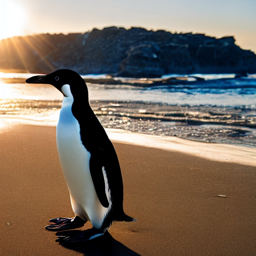

In [5]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# 配置DDIM调度器
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# 采样一次，保证代码正常
prompt = 'Beautiful DSLR Photograph of a penguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'

im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256))  # 调整至有利于查看的尺寸

#### 2.DDIM采样

在给定时刻t，带有噪声的图像$x_t$是对原始图像$x_0$加上高斯噪声$\epsilon$得到的。DDPM中给出了$x_t$的计算方法：
$x_t=\sqrt{\alpha_t}x_{t-1}+\sqrt{1-\alpha_t}\epsilon\quad\text{with }\epsilon\sim\mathcal{N}(\epsilon;\mathbf{0},\mathbf{I})$
其中$\epsilon$是方差归一化后的高斯噪声，$\alpha_t$在DDPM论文中被称为$\bar{\alpha}$，并被用于定义噪声调度器。在扩散模型中，$\alpha$被计算并排序存储在`scheduler.alphas_cumprod`中。

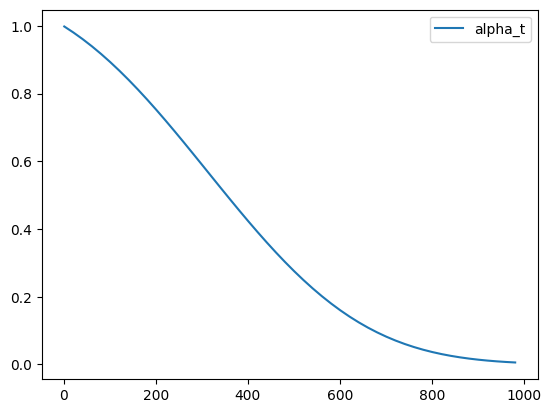

In [6]:
# 选择使用Diffusers中的alphas_cumprod函数来得到alphas
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t');
plt.legend();

在图上可以看出，噪声曲线由无噪的干净的图像开始，此时$\alpha_t=1$。在到达更高的时间步后，便得到一幅几乎全是噪声的图像，$\alpha_t$也几乎下降到0。为了计算采样轨迹中下一个时刻的值$x_{t-1}$（因为是从后向前移动的），我们


*   首先需要得到预测噪声（模型输出）$\epsilon_\theta(x_t)$；
*   随后用此噪声预测不带噪声的图像$x_0$；
*   接下来朝着“反转"的方向移动一步；
*   最后可以加上一些带有$\sigma_t$系数的额外噪声

在DDIM的原论文中是这样描述的：
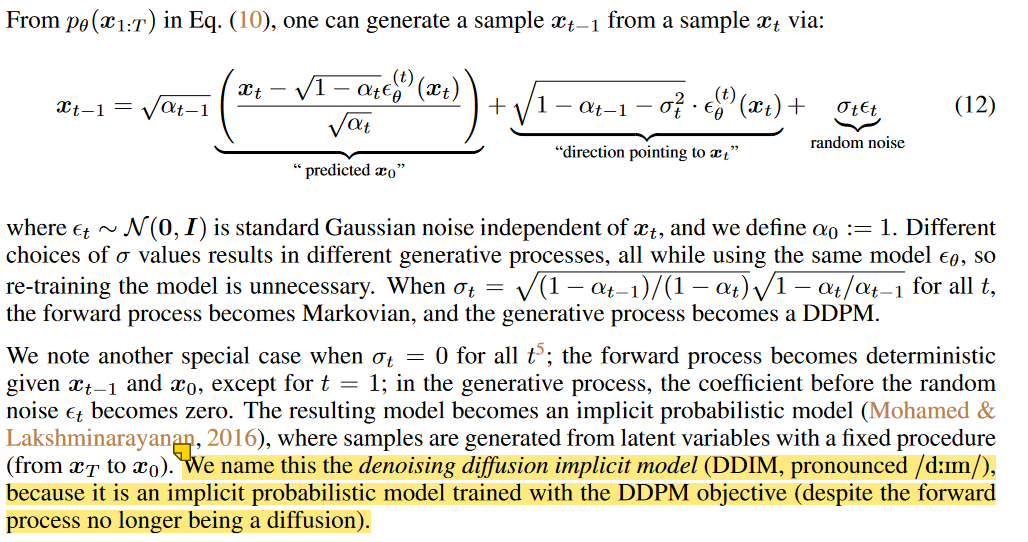

翻译如下：
根据公式(10)中的$p_{\theta}(x_{1:T})$，可以通过公式(12)从$x_t$推导出$x_{t-1}$，其中$\epsilon _t\sim \mathcal{N}(0,\mathrm{I})$是独立于$x_t$的标准高斯噪声，并且定义$\alpha _0=1$，使用不同的$alpha$值会导致不同的生成流程，因为同时使用了相同的模型$\epsilon _\theta$，所以不需要重新训练模型。对于所有时刻t，当$\theta_t=\sqrt{(1-\alpha _{t-1})/(1-\alpha _t)}\sqrt{1-\alpha _t/\alpha _{t-1}}$时，前向过程将变成马尔可夫过程，生成过程（逆向过程）变为DDPM。

另一个特殊情况是，即对于几乎所有时刻（t=1除外）的$\sigma_t=0$，前向过程在给定$x_{t-1}x$和$x_0$的情况下变得更加确定；在生成过程中，随机噪声$\epsilon_t$前面的系数变为0。得到的模型变成隐式概率模型（Mohamed&Lakshminarayanan，2016），其中的样本是根据固定的过程从隐变量生成的（从$x_r$到$x_0$）。将这个模型命名为“去噪扩散隐式模型”（Denoising Diffusion Implicit Model,DDIM），因为它是一个使用DDPM目标进行训练的隐式概率模型（尽管前向过程不再是扩散过程）。

In [7]:
# 采样噪声（标准DDIM采样）
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device
    ):
  # 对文本提示语进行编码
  text_embeddings = pipe._encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt)
  # 设置推理的步数
  pipe.scheduler.set_timesteps(num_inference_steps, device=device)
  # 创建随机起点
  if start_latents is None:
    start_latents = torch.randn(1, 4, 64, 64, device=device)
    start_latents *= pipe.scheduler.init_noise_sigma

  latents = start_latents.clone()
  for i in tqdm(range(start_step, num_inference_steps)):
    t = pipe.scheduler.timesteps[i]

    # 如果正在进行CFG，则对隐层进行扩展
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 预测噪声
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # 进行引导
    if do_classifier_free_guidance:
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 使用调度器更新步骤
    # Normally we'd rely on the scheduler to handle the update step:
    # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # 现在不用调度器，而是自行实现
    prev_t = max(1, t.item()-(1000//num_inference_steps)) # t-1
    alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
    alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
    predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
    direction_pointing_to_xt = (1-alpha_t_prev).sqrt()*noise_pred
    latents = alpha_t_prev.sqrt()*predicted_x0 + direction_pointing_to_xt
  # 后处理
  images = pipe.decode_latents(latents)
  images = pipe.numpy_to_pil(images)

  return images

  0%|          | 0/50 [00:00<?, ?it/s]

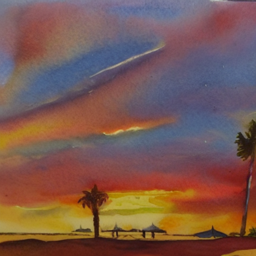

In [8]:
# 生成一张图片
prompt = 'Watercolor painting of a beach sunset'
sample(prompt, negative_prompt=negative_prompt, num_inference_steps=50)[0].resize((256, 256))

### 3.反转（invert）
反转的目标是“颠倒”采样的过程（采样的逆过程）。 最终想得到“带噪”的隐式表示，如果将其用作正常采样过程的起点，那么生成的将是原始图像。


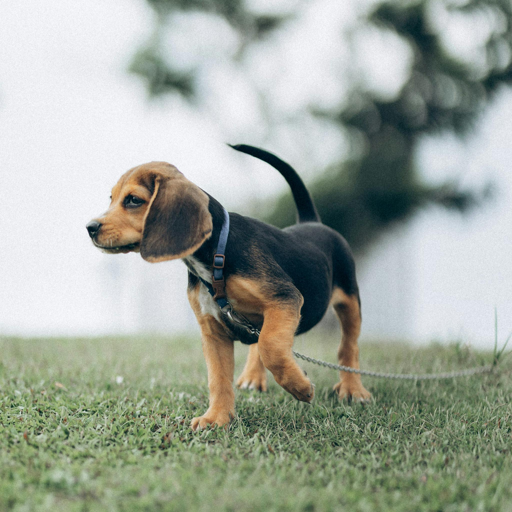

In [17]:
# 图片示例：
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image

In [16]:
# 使用一个包含无分类器引导的文本提示语来进行反转操作。
input_image_prompt = "Photograph of a puppy on the grass"
#接下来，将这幅PIL图像转换为一系列隐式表示，这些隐式表示将被用作反转操作的起点
#使用VAE进行编码
with torch.no_grad():
  latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
  l = 0.18215 * latent.latent_dist.sample()

invert函数与上文中的sample函数非常相似，但是在时间步上是朝着相反的方向移动的：从t=0开始，向噪声更多的方向移动，而不是在更新隐式层的过程中那样噪声越来越少。可以利用预测的噪声来撤回一步更新操作，并从t移动到t+1。

In [12]:
# 定义invert函数
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device):
  # 对提示文本进行编码
  text_embeddings = pipe._encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt)
  # 指定起点
  latents = start_latents.clone()
  # 用一个列表保存反转的隐层
  intermediate_latents = []
  # 设置推理的步数
  pipe.scheduler.set_timesteps(num_inference_steps, device=device)
  # 反转的时间步
  timesteps = reversed(pipe.scheduler.timesteps)

  for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):
    # 跳过最后一次迭代
    if i >= num_inference_steps - 1: continue
    t = timesteps[i]
    # 如果正在进行CFG，则对隐层进行扩展
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    # 预测残留的噪声
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    # 引导
    if do_classifier_free_guidance:
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_t = max(0, t.item() - (1000//num_inference_steps)) # t
    next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
    alpha_t = pipe.scheduler.alphas_cumprod[current_t]
    alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

    # 反转的更新步（重新排列更新步，利用当前隐层得到新的隐层）
    latents = (latents - (1-alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (1-alpha_t_next).sqrt() * noise_pred
    # 保存隐层
    intermediate_latents.append(latents)
  return torch.cat(intermediate_latents)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

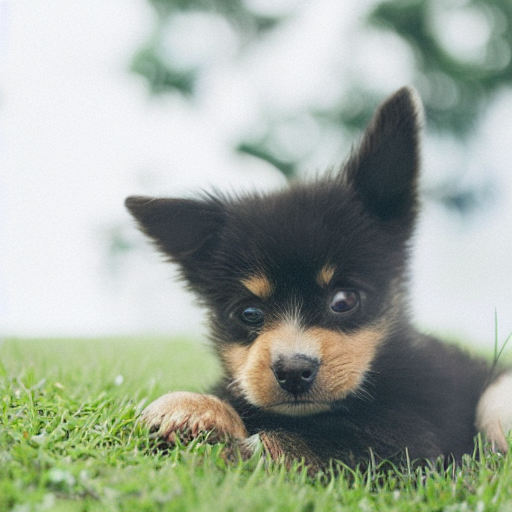

In [15]:
# 将invert函数应用于示例图片，得到在反转的过程中的一系列隐式表达：
inverted_latents = invert(l, input_image_prompt,num_inference_steps=50)
inverted_latents.shape  # torch.Size([48, 4, 64, 64])
# 最后的隐式表达
# 解码反转的最后一个隐层
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]
# 将其作为起点噪声，通过常规调用方法call，将反转隐式地传递给pipeline：
pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]

显然，这并不是最初的那张照片。这是**因为DDIM反转需要一个重要的假设：在时刻 t 预测的噪声与在时刻 t+1 预测的噪声相同，但这个假设在反转50步或者100步时是不成立的。**

当然，既可以使用更多的时间步来得到更准确的反转，也可以采取“作弊”的方式，直接从相应反转过程50步中的第20步的隐式表达开始，代码如下：

  0%|          | 0/30 [00:00<?, ?it/s]

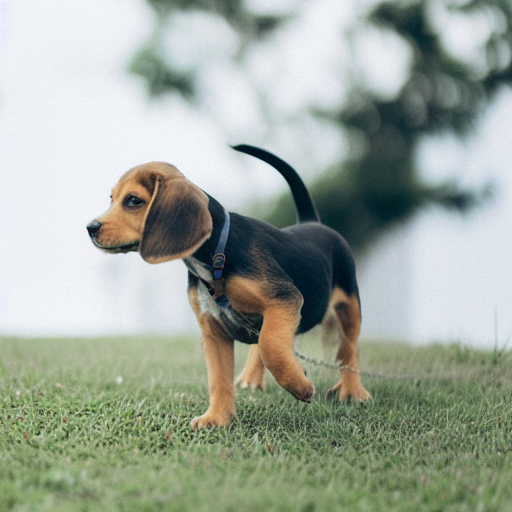

In [18]:
# 从第20步的隐式表示开始，得到的结果距离最初的图片很近了！
start_step=20
sample(input_image_prompt, start_latents=inverted_latents[-(start_step+1)][None],
       start_step=start_step, num_inference_steps=50)[0]

显然，得到的结果与最初的图片很接近。

但是，为什么要这么做呢？因为现在想用一个新的提示语来生成图片。想要得到一张除了与提示语相关以外，其他内容都与原始图片大致相同的图片。例如：把小狗换成小猫

  0%|          | 0/40 [00:00<?, ?it/s]

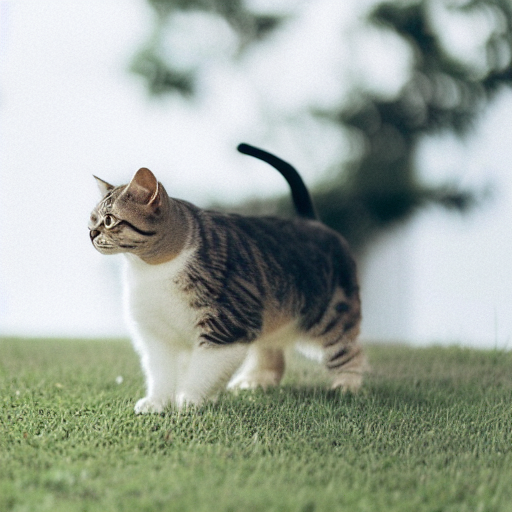

In [19]:
# 把小狗换成小猫，从第10步的隐式表示开始
start_step=10
new_prompt = input_image_prompt.replace('puppy', 'cat')
sample(new_prompt, start_latents=inverted_latents[-(start_step+1)][None],
       start_step=start_step, num_inference_steps=50)[0]

还有一个问题是，为什么不直接使用Img2Img pipline呢？或者是为什么要做反转？为什么不直接对输入图像添加噪声，然后用新的文本提示语直接“去噪”呢？当然可以，但是这会导致图片变化非常大或者图片没什么变化。如下所示

  0%|          | 0/40 [00:00<?, ?it/s]

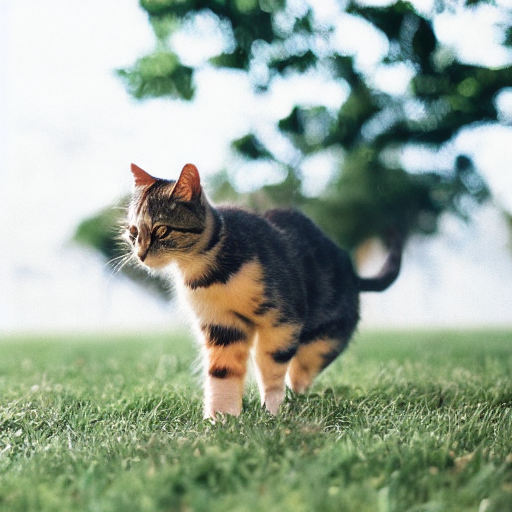

In [20]:
start_step=10
num_inference_steps=50
pipe.scheduler.set_timesteps(num_inference_steps)
noisy_1 = pipe.scheduler.add_noise(l, torch.randn_like(l), pipe.scheduler.timesteps[start_step])
sample(new_prompt, start_latents=noisy_1, start_step=start_step, num_inference_steps=num_inference_steps)[0]

### 4.封装
将所有代码封装到一个函数中，输入一张图片和两个文本提示语，得到一张通过反转得到的修改后的图片：

In [21]:
def edit(input_image, input_image_prompt, edit_prompt, num_steps=100, start_step=30, guidance_scale=3.5):
  with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
  l = 0.18215 * latent.latent_dist.sample()
  inverted_latents = invert(l, input_image_prompt,num_inference_steps=num_steps)
  final_im = sample(edit_prompt, start_latents=inverted_latents[-(start_step+1)][None],
                    start_step=start_step,
                    num_inference_steps=num_steps,
                    guidance_scale=guidance_scale)[0]
  return final_im

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

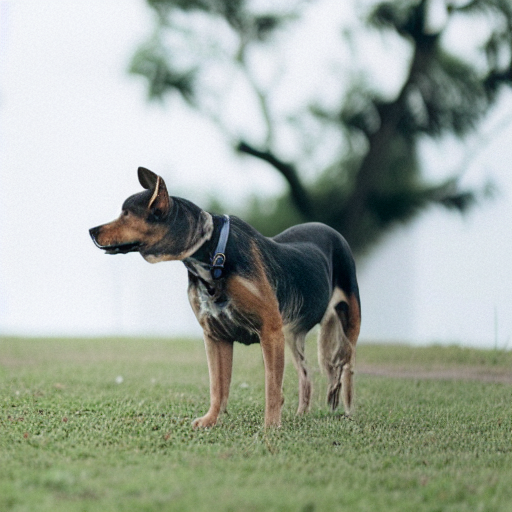

In [22]:
# 示例
edit(input_image, 'A puppy on the grass', 'an old grey dog on the grass', num_steps=50, start_step=10)